In [1]:
import numpy as np
import pandas as pd
import pyjags
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [3]:
y_train = train['Survived']
X_train = train[['Pclass']]
X_train['Age'] = train['Age'].fillna(np.mean(train['Age']))
X_train['Sex'] = pd.Categorical(train['Sex']).codes
X_train['SibSp_log'] = train.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

X_test = test[['Pclass']]
X_test['Age'] = test['Age'].fillna(np.mean(test['Age']))
X_test['Sex'] = pd.Categorical(test['Sex']).codes
X_test['SibSp_log'] = test.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [4]:
X_train.head()

,Pclass,Age,Sex,SibSp_log
0,3,22.0,1,0.693147
1,1,38.0,0,0.693147
2,3,26.0,0,0.000000
3,1,35.0,0,0.693147
4,3,35.0,1,0.000000


In [8]:
code = '''
model {
    for (i in 1:length(y)) {
        y[i] ~ dbern(p[i])
        grp[i] = 3 * Sex[i] + Pclass[i]
        logit(p[i]) = alpha[grp[i]] + beta[grp[i]]*Age[i] + gamma[grp[i]]*SibSp_log[i]
    }
    
    for (j in 1:6) {
        alpha[j] ~ dnorm(0.0, 1.0/1.0e6)        
        beta[j] ~ dnorm(mu_b, prec_b)
        gamma[j] ~ dnorm(mu_g, prec_g)
    }
    
    mu_b ~ dnorm(0, 1.0/1.0e6)
    prec_b ~ dgamma(1.0, 1.0)
    
    mu_g ~ dnorm(0, 1.0/1.0e6)
    prec_g ~ dgamma(1.0, 1.0)    
}
'''

In [9]:
data = dict(
    y = y_train, 
    Sex = X_train['Sex'], 
    Pclass = X_train['Pclass'], 
    Age = X_train['Age'], 
    SibSp_log = X_train['SibSp_log'])

In [10]:
model = pyjags.Model(code, data=data, chains=4)
samples = model.sample(15000, vars=['alpha', 'beta', 'gamma'])

adapting: iterations 3748 of 4000, elapsed 0:00:09, remaining 0:00:01
adapting: iterations 4000 of 4000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 3584 of 60000, elapsed 0:00:09, remaining 0:02:19
sampling: iterations 5608 of 60000, elapsed 0:00:14, remaining 0:02:14
sampling: iterations 7632 of 60000, elapsed 0:00:19, remaining 0:02:09
sampling: iterations 11680 of 60000, elapsed 0:00:29, remaining 0:01:59
sampling: iterations 15728 of 60000, elapsed 0:00:39, remaining 0:01:49
sampling: iterations 19784 of 60000, elapsed 0:00:49, remaining 0:01:39
sampling: iterations 21812 of 60000, elapsed 0:00:54, remaining 0:01:34
sampling: iterations 25868 of 60000, elapsed 0:01:04, remaining 0:01:24
sampling: iterations 29924 of 60000, elapsed 0:01:14, remaining 0:01:14
sampling: iterations 33980 of 60000, elapsed 0:01:24, remaining 0:01:04
sampling: iterations 38040 of 60000, elapsed 0:01:34, remaining 0:00:54
sampling: iterations 40072 of 60000, elapsed 0:01:39, remaining 0:00:49

In [11]:
def draw(samples, name, h, w, n):
    print(name)
    f, axarr = plt.subplots(h, w)
    f.set_size_inches(15, 15)
    for i in range(n):
        axarr[i // w, i % w].plot(samples['alpha'][0])
    plt.show()

alpha


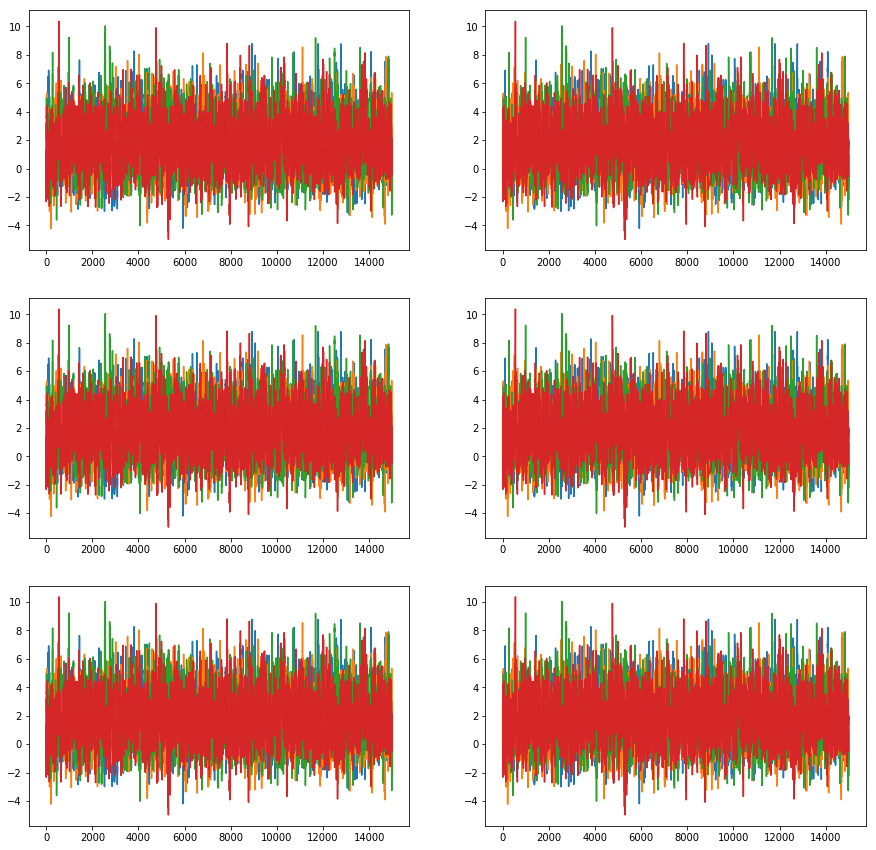

beta


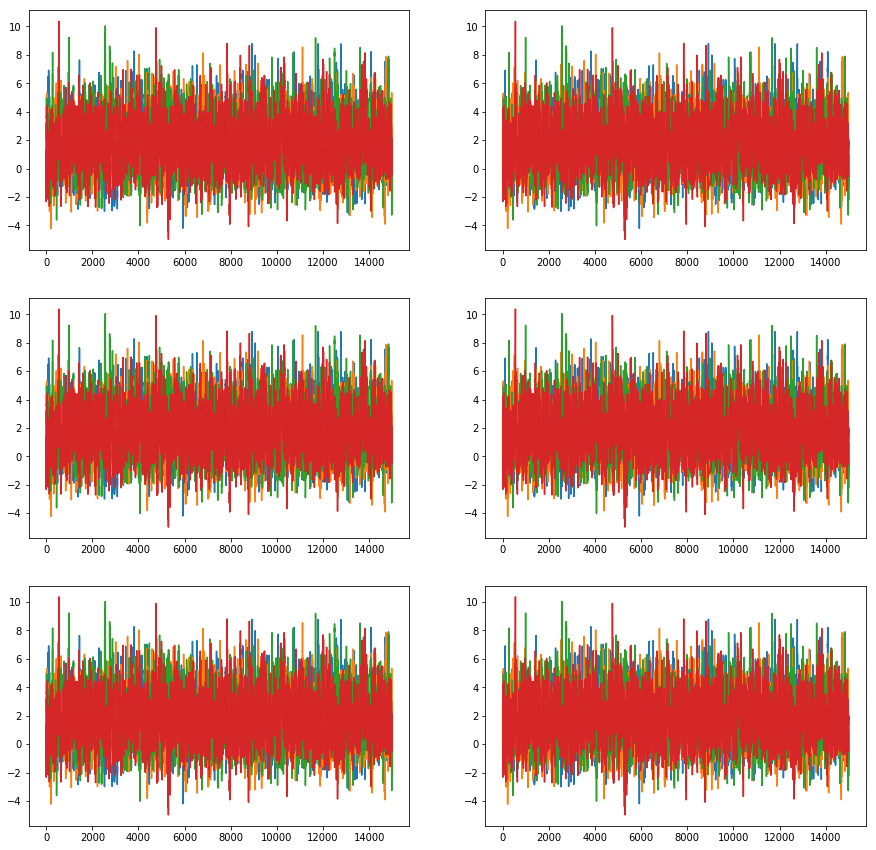

gamma


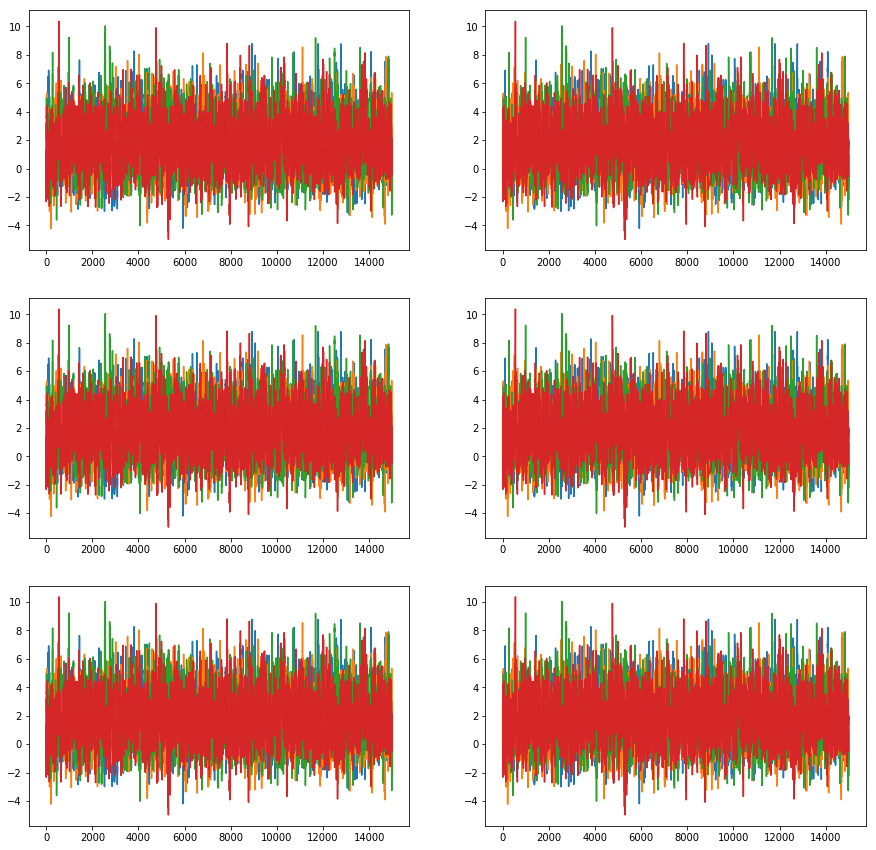

In [12]:
draw(samples, 'alpha', 3, 2, 6)
draw(samples, 'beta', 3, 2, 6)
draw(samples, 'gamma', 3, 2, 6)

In [13]:
def getMeans(samples, name):
    N = len(samples[name])
    x = np.zeros(N)
    for i in range(N):
        x[i] = np.mean(samples[name][i])
    return x

In [14]:
alpha = getMeans(samples, 'alpha')
beta = getMeans(samples, 'beta')
gamma = getMeans(samples, 'gamma')

In [15]:
print(alpha)
print(beta)
print(gamma)

[ 1.87631312  4.69105581  1.21033629  0.60354831  0.984375   -0.22228062]
[ 0.07110722 -0.05898932 -0.03157595 -0.03178608 -0.10686627 -0.05875817]
[-0.41950209 -0.43843608 -1.06356417  0.3251442  -0.05658159 -0.665905  ]


In [16]:
def predict(Pclass, Age, Sex, SibSp_log):
    global alpha
    global beta
    global gamma
    
    grp = 3 * int(Sex) + int(Pclass) - 1
    t = alpha[grp] + beta[grp]*Age + gamma[grp]*SibSp_log
    p = 1.0 / (1.0 + math.exp(-t))
    
    if p > 0.5:
        return 1
    else:
        return 0  

In [17]:
predicted = X_train.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [18]:
print('Accuracy', sum(predicted == y_train) / len(y_train))

Accuracy 0.824915824916


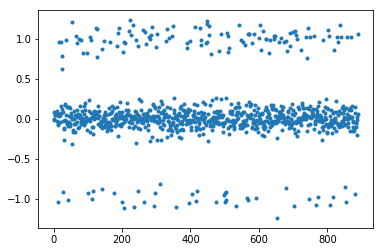

In [19]:
plt.plot(y_train - predicted + np.random.normal(0, 0.1, len(y_train)), '.')

In [20]:
# Prediction for Kaggle

test_predicted = X_test.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [21]:
def writeAnswer(filename, prediction):
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })
    submission.to_csv(filename, index=False)
    
writeAnswer('Hierarchical.csv', test_predicted)